In [1]:
using Pkg
Pkg.add("TSPLIB")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


12861.0


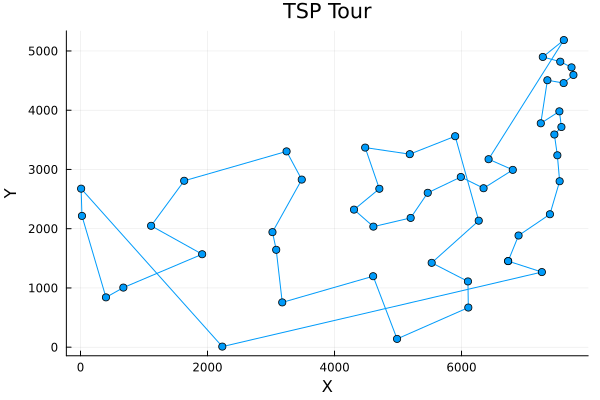

In [1]:
using TSPLIB
using Plots

tsp_instance = readTSPLIB(:att48)

function draw_tour(coordinates, tour)
    # Adjust indexing for a matrix where each row is a city's [x, y] coordinates
    xs = [coordinates[city, 1] for city in tour]  # Access the x-coordinate
    ys = [coordinates[city, 2] for city in tour]  # Access the y-coordinate
    # Add the first city again to close the loop
    push!(xs, coordinates[tour[1], 1])
    push!(ys, coordinates[tour[1], 2])
    plot(xs, ys, title = "TSP Tour", xlabel = "X", ylabel = "Y", legend = false, marker = :circle)
end

function calc_tour_distance(tour, weights)
    total_distance = 0.0
    number_of_cities = length(tour)
    for i in 1:(number_of_cities - 1)
        total_distance += weights[tour[i], tour[i + 1]]
    end
    # Add distance from last city back to first to complete the tour
    total_distance += weights[tour[number_of_cities], tour[1]]
    return total_distance
end

function solve_tsp_nearest_neighbor(tsp_instance)
    distances = tsp_instance.weights
    coordinates = tsp_instance.nodes
    n = size(distances, 1)
    visited = Bool[false for _ in 1:n]
    tour = Int[1]
    visited[1] = true
    for _ in 1:(n-1)
        last_city = tour[end]
        nearest_neighbor = nothing
        min_distance = Inf
        for city in 1:n
            if !visited[city] && distances[last_city, city] < min_distance
                nearest_neighbor = city
                min_distance = distances[last_city, city]
            end
        end
        push!(tour, nearest_neighbor)
        visited[nearest_neighbor] = true
    end
    println(calc_tour_distance(tour, distances))
    draw_tour(coordinates, tour)
end

solve_tsp_nearest_neighbor(tsp_instance)

12727.0


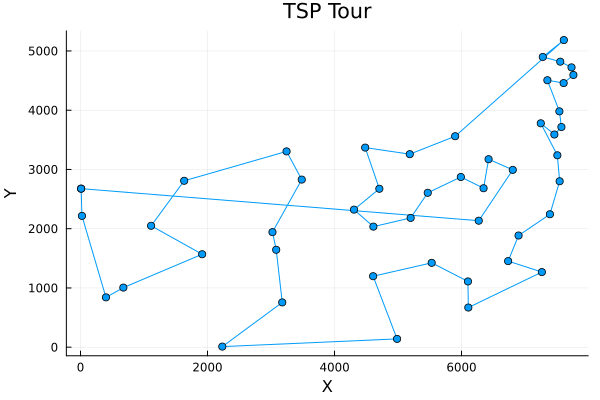

In [2]:
function solve_tsp_greedy(tsp_instance)
    distances = tsp_instance.weights
    coordinates = tsp_instance.nodes
    edges_with_weights = []
    n = size(tsp_instance.weights, 1)
    for i in 1:n-1
        for j in i+1:n
            dist = tsp_instance.weights[i, j]
            push!(edges_with_weights, ((i, j), dist))
        end
    end
    # Sort edges by weight (distance)
    sorted_edges_with_weights = sort(edges_with_weights, by = x -> x[2])
    # Initialize an empty adjacency list to track connections between nodes
    adjacency_list = Dict{Int, Set{Int}}()
    # Function to add an edge to the adjacency list
    function add_edge(node1, node2)
        if !haskey(adjacency_list, node1)
            adjacency_list[node1] = Set{Int}()
        end
        if !haskey(adjacency_list, node2)
            adjacency_list[node2] = Set{Int}()
        end
        push!(adjacency_list[node1], node2)
        push!(adjacency_list[node2], node1)
    end
    # Check if adding an edge creates a small cycle
    function forms_small_cycle(node1, node2, total_nodes)
        if !haskey(adjacency_list, node1) || !haskey(adjacency_list, node2)
            return false
        end
        visited = Set{Int}()
        function dfs(current, target)
            if current == target
                return true
            end
            push!(visited, current)
            for neighbor in adjacency_list[current]
                if !in(neighbor, visited) && dfs(neighbor, target)
                    return true
                end
            end
            return false
        end
        return dfs(node1, node2)
    end
    total_nodes = length(unique(reduce(vcat, [[edge[1][1], edge[1][2]] for edge in sorted_edges_with_weights])))
    for edge in sorted_edges_with_weights
        node1, node2 = edge[1]
        if !(node1 in keys(adjacency_list) && length(adjacency_list[node1]) == 2) &&
           !(node2 in keys(adjacency_list) && length(adjacency_list[node2]) == 2) &&
           !forms_small_cycle(node1, node2, total_nodes)
            add_edge(node1, node2)
        end
    end
    # Find the starting node (one of the nodes with only one connection)
    # Revised snippet to find the start node correctly
    start_node = 0
    for (node, neighbors) in adjacency_list
        if length(neighbors) == 1
            start_node = node
            break
        end
    end
    function reconstruct_path(start_node, adjacency_list)
        path = [start_node]
        current_node = start_node
    
        while true
            neighbors = adjacency_list[current_node]
            # Find the next node that is not already in the path
            next_node = nothing
            for neighbor in neighbors
                if neighbor ∉ path
                    next_node = neighbor
                    break
                end
            end
            # Break the loop if no next node is found, indicating the path is complete
            if isnothing(next_node)
                break
            end
            push!(path, next_node)
            current_node = next_node
            # Optionally, add a check to prevent infinite loops in case of logic errors
            if length(path) > length(adjacency_list)
                println("Error: Path is longer than the number of nodes, indicating a loop.")
                break
            end
        end
        return path
    end
    tour = reconstruct_path(start_node, adjacency_list)
    println(calc_tour_distance(tour, distances))
    draw_tour(coordinates, tour)
end

solve_tsp_greedy(tsp_instance)

In [3]:
function f_tsp_AO(tsp_instance, indiv, draw = false)
    distances = tsp_instance.weights
    coordinates = tsp_instance.nodes
    n = size(tsp_instance.weights, 1)
    function transform_vector(vec, n)
        result = Any[]
        # Counter for the vector's index
        vec_index = 1
        # Loop through all possible pairs
        for i in 1:(n-1)
            for j in (i+1):n
                # Append the tuple ((i, j), vec[vec_index]) to the result array
                push!(result, ((i, j), vec[vec_index]))
                vec_index += 1
            end
        end
        return result
    end
    weights = transform_vector(indiv, n)
    sorted_edges_with_weights = sort(weights, by = x -> x[2])
    # Initialize an empty adjacency list to track connections between nodes
    adjacency_list = Dict{Int, Set{Int}}()
    # Function to add an edge to the adjacency list
    function add_edge(node1, node2)
        if !haskey(adjacency_list, node1)
            adjacency_list[node1] = Set{Int}()
        end
        if !haskey(adjacency_list, node2)
            adjacency_list[node2] = Set{Int}()
        end
        push!(adjacency_list[node1], node2)
        push!(adjacency_list[node2], node1)
    end
    # Check if adding an edge creates a small cycle
    function forms_small_cycle(node1, node2, total_nodes)
        if !haskey(adjacency_list, node1) || !haskey(adjacency_list, node2)
            return false
        end
        visited = Set{Int}()
        function dfs(current, target)
            if current == target
                return true
            end
            push!(visited, current)
            for neighbor in adjacency_list[current]
                if !in(neighbor, visited) && dfs(neighbor, target)
                    return true
                end
            end
            return false
        end
        return dfs(node1, node2)
    end
    total_nodes = length(unique(reduce(vcat, [[edge[1][1], edge[1][2]] for edge in sorted_edges_with_weights])))
    for edge in sorted_edges_with_weights
        node1, node2 = edge[1]
        if !(node1 in keys(adjacency_list) && length(adjacency_list[node1]) == 2) &&
           !(node2 in keys(adjacency_list) && length(adjacency_list[node2]) == 2) &&
           !forms_small_cycle(node1, node2, total_nodes)
            add_edge(node1, node2)
        end
    end
    # Find the starting node (one of the nodes with only one connection)
    # Revised snippet to find the start node correctly
    start_node = 0
    for (node, neighbors) in adjacency_list
        if length(neighbors) == 1
            start_node = node
            break
        end
    end
    function reconstruct_path(start_node, adjacency_list)
        path = [start_node]
        current_node = start_node
    
        while true
            neighbors = adjacency_list[current_node]
            # Find the next node that is not already in the path
            next_node = nothing
            for neighbor in neighbors
                if neighbor ∉ path
                    next_node = neighbor
                    break
                end
            end
            # Break the loop if no next node is found, indicating the path is complete
            if isnothing(next_node)
                break
            end
            push!(path, next_node)
            current_node = next_node
            # Optionally, add a check to prevent infinite loops in case of logic errors
            if length(path) > length(adjacency_list)
                println("Error: Path is longer than the number of nodes, indicating a loop.")
                break
            end
        end
        return path
    end
    tour = reconstruct_path(start_node, adjacency_list)
    if draw == true
        display(draw_tour(coordinates, tour))
    end
    return calc_tour_distance(tour, distances)
end

f_tsp_AO (generic function with 2 methods)

In [4]:
#using Pkg
#Pkg.add("SpecialFunctions")
using SpecialFunctions
using Statistics
using Plots

function calculate_g1()
    # rand motion, Eq. 16
    return 2 * rand() - 1  # Eq. 16
end

function calculate_g2(iteration::Integer, max_iterations::Integer)
    # Flight slope of aquila, Eq. 17
    return 2 * (1 - iteration / max_iterations)
end

function calculate_spiral_search(
    num_dimensions::Integer,
    r1::Float64,
    miu::Float64,
    w::Float64
)
    # Spiral search Eq.(9, 10)
    dim_list = [i for i in range(1, num_dimensions)]
    r = r1 .+ miu .* dim_list
    phi0 = 3 * pi / 2
    phi = -w .* dim_list .+ phi0
    x = r .* sin.(phi)  
    y = r .* cos.(phi)  

    return x, y
end

function calculate_quality_function(
    iteration::Integer, 
    max_iterations::Integer
)
    # Quality function, Eq.(15)
    iteration ^ ((2 * rand() - 1) / (1 - max_iterations) ^ 2)  
end

function get_levy_flight_step(
    beta::Float64
)
    # u and v are two rand variables which follow normal distribution
    # sigma_u : standard deviation of u
    sigma = gamma(1.0 + beta) * sin(pi * beta / 2) / (gamma((1 + beta) / 2.) * beta * (2. ^ ((beta - 1) / 2)))

    # levy step, Eq. 6
    step = rand() * sigma / (abs(rand()) ^ (1 / beta))
    
    return step
end

function generate_initial_pop(lower, upper, dimensions, pop_size)
    positions = rand(pop_size, dimensions) .* (upper - lower) .+ lower
    return positions
end

function greedy_initialization(tsp_instance, pop_size, noise)
    n = size(tsp_instance.weights, 1)
    vector_length = n*(n-1)÷2
    positions = Matrix{Float64}(undef, pop_size, vector_length)
    
    for k in 1:pop_size
        vector = []
        idx = 1
        for i in 1:n-1
            for j in i+1:n
                dist = tsp_instance.weights[i, j] + rand() * noise
                push!(vector, dist)
            end
        end
        positions[k, :] = vector
    end
    return positions
end


function get_best_position(f,
    population::Array{Float64, 2},
    fitness::Array{Float64, 1}
)
    min_index = argmin(fitness)
    return population[min_index, :], fitness[min_index]
end

function expanded_exploration(
    best_position::Array{Float64, 1},
    iteration::Integer,
    max_iterations::Integer,
    x_mean::Array{Float64, 1}
)
    return best_position * (1 - iteration / max_iterations) .+ rand() * (x_mean .- best_position)
end


function rand_individual(
    population::Array{Float64, 2},
    skip_index::Integer
)
    # Get the number of individuals in the population
    num_individuals = size(population, 1)
    
    # Filter out the skip_index
    filtered_indices = filter(x -> x != skip_index, 1:num_individuals)

    # Select a random index from the filtered array
    index = rand(filtered_indices)

    return population[index, :]
end


function narrowed_exploration(
    current_index::Integer,
    population::Array{Float64, 2},
    best_position::Array{Float64, 1},
    beta::Float64,
    r1::Float64,
    miu::Float64,
    w::Float64
)
    levy_step = get_levy_flight_step(beta)
    
    # Define spiral search
    x, y = calculate_spiral_search(size(population, 2), r1, miu, w)

    # Use Eq. 5 to compute narrowed exploration
    return best_position * levy_step .+ rand_individual(population, current_index) .+ rand() * (y - x)  
end

function expanded_exploitation(
    alpha::Float64,
    delta::Float64,
    best_position::Array{Float64, 1},
    x_mean::Array{Float64, 1},
    upper::Array{Float64, 1},
    lower::Array{Float64, 1}
)
    # Compute expanded exploitation from Eq. 13
    return alpha .* (best_position .- x_mean) - rand() .* (rand() .* (upper .- lower) .+ lower) .* delta
end

function narrowed_exploitation(
    iteration::Integer,
    max_iterations::Integer,
    individual::Array{Float64, 1},
    best_position::Array{Float64, 1},
    beta::Float64
)
    levy_step = get_levy_flight_step(beta)

    # Quality function
    qf = calculate_quality_function(iteration, max_iterations)

    # Flight slope and rand movement parameters
    g1 = calculate_g1()
    g2 = calculate_g2(iteration, max_iterations)

    # Eq. 14
    return qf .* best_position .- (g2 .* individual .* rand()) .- g2 .* levy_step .+ rand() .* g1  
end

function evolve!(f,
    tsp_instance,
    positions,
    fitness,
    upper::Array{Float64, 1},
    lower::Array{Float64, 1},
    max_iterations:: Integer,
    alpha::Float64 = 0.1,
    delta::Float64 = 0.1,
    r1::Float64 = 10.0,
    miu::Float64 = 0.00565,
    w::Float64 = 0.005,
    beta::Float64 = 1.5
)
    best_fitness_array = []
    
    # Calculate global population values
    best_position, best_fitness = get_best_position(f, positions, fitness)

    for iteration in 1:max_iterations
        println(best_fitness, ' ', mean(fitness))
        push!(best_fitness_array, best_fitness)
        # Generate a new population. Assume this happens in place?
        for idx in 1:size(positions, 1)
            # Update mean each time as individuals update positions
            x_mean = vec(mean(positions, dims=1))
    
            # Find a new position for this individual
            if iteration <= (2 / 3) * max_iterations
                if rand() < 0.5
                    pos_new = expanded_exploration(best_position, iteration, max_iterations, x_mean)
                else
                    pos_new = narrowed_exploration(idx, positions, best_position, beta, r1, miu, w)
                end
            else
                if rand() < 0.5
                    pos_new = expanded_exploitation(alpha, delta, best_position, x_mean, upper, lower)
                else
                    pos_new = narrowed_exploitation(iteration, max_iterations, positions[idx, :], best_position, beta)
                end
            end
            
            # Evaluate the position
            fitness_new = f(tsp_instance, pos_new)
            
            # If better, replace
            if fitness_new < fitness[idx]
                positions[idx, :] = pos_new
                fitness[idx] = fitness_new
                
                if fitness_new < best_fitness
                    best_position = pos_new
                    best_fitness = fitness_new                
                end
            end
        end
    end
    return best_position
end

function AO_solve_TSP(f, tsp_instance, pop_size, max_iterations)
    n = size(tsp_instance.weights, 1)
    dimensions = n * (n - 1) ÷ 2
    # positions = generate_initial_pop(0.0, 1.0, dimensions, pop_size)
    positions = greedy_initialization(tsp_instance, pop_size, 200)
    fitness = [f(tsp_instance, positions[i, :]) for i in 1:pop_size]
    best_position = evolve!(f,
    tsp_instance,
    positions,
        
    fitness,
    fill(1.0, dimensions),
    fill(0.0, dimensions),
    max_iterations)

    f(tsp_instance, best_position, true)
end

AO_solve_TSP (generic function with 1 method)

11894.0 13346.3
11894.0 13056.0
11894.0 12812.833333333334
11894.0 12664.2
11894.0 12520.633333333333
11894.0 12419.0
11654.0 12259.633333333333
11107.0 11944.733333333334
11107.0 11681.533333333333
11107.0 11440.433333333332
11107.0 11148.0
11107.0 11115.2
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.0 11107.0
11107.

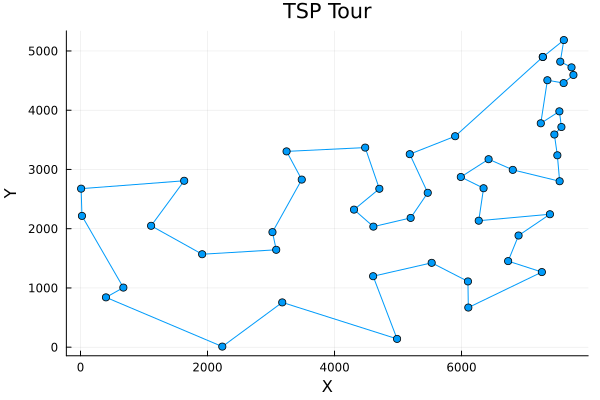

11107.0

In [5]:
# Define optimization parameters
f = f_tsp_AO
pop_size = 30
max_iterations = 100

AO_solve_TSP(f, tsp_instance, pop_size, max_iterations)